<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/10_ObjectLocalization/TinyImageNet/TinyImageNet_With_Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary
!pip install hiddenlayer
!pip install torch-lr-finder

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-zr4qakx0
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-zr4qakx0
  Created wheel for albumentations: filename=albumentations-1.0.3-cp37-none-any.whl size=98746 sha256=21f0db406e74a80e1a3a14f95c673b6efca8da50408020261619b49b7abde588
  Stored in directory: /tmp/pip-ephem-wheel-cache-qxkkbn9a/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
!git clone https://github.com/gkdivya/torch_cv_wrapper.git /content/drive/MyDrive/TinyImageNet/session10/torch_cv_wrapper

fatal: destination path '/content/drive/MyDrive/TinyImageNet/session10/torch_cv_wrapper' already exists and is not an empty directory.


In [5]:
%cd "/content/drive/MyDrive/TinyImageNet/session10/"
from __future__ import print_function
import torchvision
import torch
from pprint import pprint
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Import Custom Libraries
from torch_cv_wrapper.utils import plot_metrics,train,test,helper
from torch_cv_wrapper.utils.gradcam import generate_gradcam, plot_gradcam
from torch_cv_wrapper.model import resnet18
from torch_cv_wrapper.main import TriggerEngine

/content/drive/MyDrive/TinyImageNet/session10


In [6]:
config = helper.process_config("/content/drive/MyDrive/TinyImageNet/session10/session10.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'type': 'TinyImageNetAlbumentation'},
 'data_loader': {'args': {'batch_size': 512,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': 'None',
                 'type': 'TinyImageNetDataLoader'},
 'lr_finder': {'lr_epochs': 25, 'max_epoch': 5},
 'lr_scheduler': 'OneCycleLR',
 'model': 'Resnet18',
 'model_params': {'dropout': 0.05,
                  'experiment_name': 'TinyImageNet',
                  'model_dir': './model/',
                  'seed': 1},
 'optimizer': {'args': {'lr': 0.01}, 'type': 'optim.SGD'},
 'training_params': {'epochs': 50, 'l1_factor': 0, 'l2_factor': 0.005}}


In [7]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']
trigger_training=TriggerEngine(config)

In [8]:
# #Get dataloaders
train_loader,test_loader = trigger_training.dataloader()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


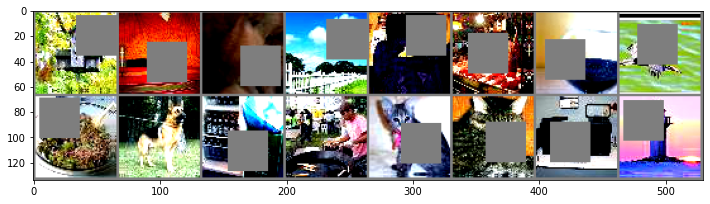

In [9]:
# get some random training images
images, labels = iter(train_loader).next()

# # show images
helper.imshow(torchvision.utils.make_grid(images[:16]))

In [10]:
images[0].shape

torch.Size([3, 64, 64])

In [11]:
model = resnet18.ResNet18()
model.to(device)
trigger_training.model_summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


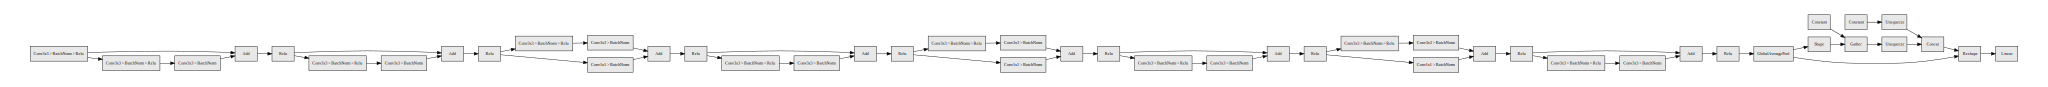

In [12]:
import hiddenlayer as hl
input = torch.zeros([1, 3, 64, 64])
hl.build_graph(model, input.to(device))

In [13]:
trigger_training=TriggerEngine(config)
(exp_metrics[experiment_name]) = trigger_training.run_experiment(model,train_loader,test_loader)

  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1:


Loss=5.091547966003418 Batch_id=150 LR=0.00050 Accuracy=1.75: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 882/33000 (2.67%)

Epoch 2:


Loss=4.82012414932251 Batch_id=150 LR=0.00082 Accuracy=3.85: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 1459/33000 (4.42%)

Epoch 3:


Loss=4.636073589324951 Batch_id=150 LR=0.00132 Accuracy=6.01: 100%|██████████| 151/151 [02:17<00:00,  1.10it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 2293/33000 (6.95%)

Epoch 4:


Loss=4.487666130065918 Batch_id=150 LR=0.00199 Accuracy=8.33: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 2378/33000 (7.21%)

Epoch 5:


Loss=3.9975674152374268 Batch_id=150 LR=0.00280 Accuracy=11.07: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 3361/33000 (10.18%)

Epoch 6:


Loss=3.866684675216675 Batch_id=150 LR=0.00372 Accuracy=13.88: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 4165/33000 (12.62%)

Epoch 7:


Loss=3.742424249649048 Batch_id=150 LR=0.00470 Accuracy=16.23: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 5371/33000 (16.28%)

Epoch 8:


Loss=3.637399673461914 Batch_id=150 LR=0.00571 Accuracy=18.63: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 5774/33000 (17.50%)

Epoch 9:


Loss=3.4604897499084473 Batch_id=150 LR=0.00669 Accuracy=21.02: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 6131/33000 (18.58%)

Epoch 10:


Loss=3.4397997856140137 Batch_id=150 LR=0.00760 Accuracy=22.90: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 4814/33000 (14.59%)

Epoch 11:


Loss=3.439868688583374 Batch_id=150 LR=0.00842 Accuracy=24.80: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7322/33000 (22.19%)

Epoch 12:


Loss=3.1694271564483643 Batch_id=150 LR=0.00909 Accuracy=26.71: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6438/33000 (19.51%)

Epoch 13:


Loss=3.209366798400879 Batch_id=150 LR=0.00959 Accuracy=28.33: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6774/33000 (20.53%)

Epoch 14:


Loss=3.1407482624053955 Batch_id=150 LR=0.00990 Accuracy=29.65: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8423/33000 (25.52%)

Epoch 15:


Loss=3.1581509113311768 Batch_id=150 LR=0.01000 Accuracy=30.95: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 9346/33000 (28.32%)

Epoch 16:


Loss=2.8391220569610596 Batch_id=150 LR=0.00998 Accuracy=32.08: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 10095/33000 (30.59%)

Epoch 17:


Loss=2.7704105377197266 Batch_id=150 LR=0.00992 Accuracy=33.36: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8771/33000 (26.58%)

Epoch 18:


Loss=2.8224399089813232 Batch_id=150 LR=0.00982 Accuracy=34.38: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8495/33000 (25.74%)

Epoch 19:


Loss=2.850024938583374 Batch_id=150 LR=0.00968 Accuracy=35.57: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 9345/33000 (28.32%)

Epoch 20:


Loss=2.8315320014953613 Batch_id=150 LR=0.00950 Accuracy=36.24: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 10004/33000 (30.32%)

Epoch 21:


Loss=2.4541985988616943 Batch_id=150 LR=0.00929 Accuracy=37.35: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 9487/33000 (28.75%)

Epoch 22:


Loss=2.740875482559204 Batch_id=150 LR=0.00904 Accuracy=38.36: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 10826/33000 (32.81%)

Epoch 23:


Loss=2.5541110038757324 Batch_id=150 LR=0.00876 Accuracy=39.28: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 10731/33000 (32.52%)

Epoch 24:


Loss=2.5410029888153076 Batch_id=150 LR=0.00845 Accuracy=40.05: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 12141/33000 (36.79%)

Epoch 25:


Loss=2.4900734424591064 Batch_id=150 LR=0.00812 Accuracy=40.84: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 11680/33000 (35.39%)

Epoch 26:


Loss=2.6999526023864746 Batch_id=150 LR=0.00775 Accuracy=41.64: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 12293/33000 (37.25%)

Epoch 27:


Loss=2.2225210666656494 Batch_id=150 LR=0.00737 Accuracy=42.60: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 10663/33000 (32.31%)

Epoch 28:


Loss=2.303828477859497 Batch_id=150 LR=0.00696 Accuracy=43.32: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 11729/33000 (35.54%)

Epoch 29:


Loss=2.4579918384552 Batch_id=150 LR=0.00654 Accuracy=44.10: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 12494/33000 (37.86%)

Epoch 30:


Loss=2.470569610595703 Batch_id=150 LR=0.00611 Accuracy=44.57: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 13801/33000 (41.82%)

Epoch 31:


Loss=2.3192038536071777 Batch_id=150 LR=0.00567 Accuracy=45.62: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 13129/33000 (39.78%)

Epoch 32:


Loss=2.250009059906006 Batch_id=150 LR=0.00522 Accuracy=46.34: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 13290/33000 (40.27%)

Epoch 33:


Loss=2.2414069175720215 Batch_id=150 LR=0.00477 Accuracy=46.99: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 13512/33000 (40.95%)

Epoch 34:


Loss=2.272881269454956 Batch_id=150 LR=0.00433 Accuracy=48.15: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 13925/33000 (42.20%)

Epoch 35:


Loss=2.1395163536071777 Batch_id=150 LR=0.00388 Accuracy=48.95: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 14338/33000 (43.45%)

Epoch 36:


Loss=2.0716910362243652 Batch_id=150 LR=0.00345 Accuracy=49.81: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 14727/33000 (44.63%)

Epoch 37:


Loss=2.1168081760406494 Batch_id=150 LR=0.00303 Accuracy=50.92: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 14709/33000 (44.57%)

Epoch 38:


Loss=1.9582656621932983 Batch_id=150 LR=0.00263 Accuracy=51.86: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 14713/33000 (44.58%)

Epoch 39:


Loss=2.0790810585021973 Batch_id=150 LR=0.00224 Accuracy=52.75: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 15797/33000 (47.87%)

Epoch 40:


Loss=2.0200469493865967 Batch_id=150 LR=0.00188 Accuracy=54.11: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 15109/33000 (45.78%)

Epoch 41:


Loss=1.7824254035949707 Batch_id=150 LR=0.00154 Accuracy=55.22: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 15763/33000 (47.77%)

Epoch 42:


Loss=1.757137656211853 Batch_id=150 LR=0.00123 Accuracy=56.64: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 16397/33000 (49.69%)

Epoch 43:


Loss=1.799545168876648 Batch_id=150 LR=0.00095 Accuracy=58.23: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 17097/33000 (51.81%)

Epoch 44:


Loss=1.9074856042861938 Batch_id=150 LR=0.00071 Accuracy=59.57: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 17124/33000 (51.89%)

Epoch 45:


Loss=1.764013409614563 Batch_id=150 LR=0.00049 Accuracy=61.05: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 17724/33000 (53.71%)

Epoch 46:


Loss=1.6958951950073242 Batch_id=150 LR=0.00032 Accuracy=62.62: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 17766/33000 (53.84%)

Epoch 47:


Loss=1.4643542766571045 Batch_id=150 LR=0.00018 Accuracy=63.87: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 18172/33000 (55.07%)

Epoch 48:


Loss=1.6224192380905151 Batch_id=150 LR=0.00008 Accuracy=65.08: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 18333/33000 (55.55%)

Epoch 49:


Loss=1.606909155845642 Batch_id=150 LR=0.00002 Accuracy=65.90: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 18346/33000 (55.59%)

Epoch 50:


Loss=1.614989161491394 Batch_id=150 LR=0.00000 Accuracy=66.43: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]



Test set: Average loss: 0.0036, Accuracy: 18343/33000 (55.58%)



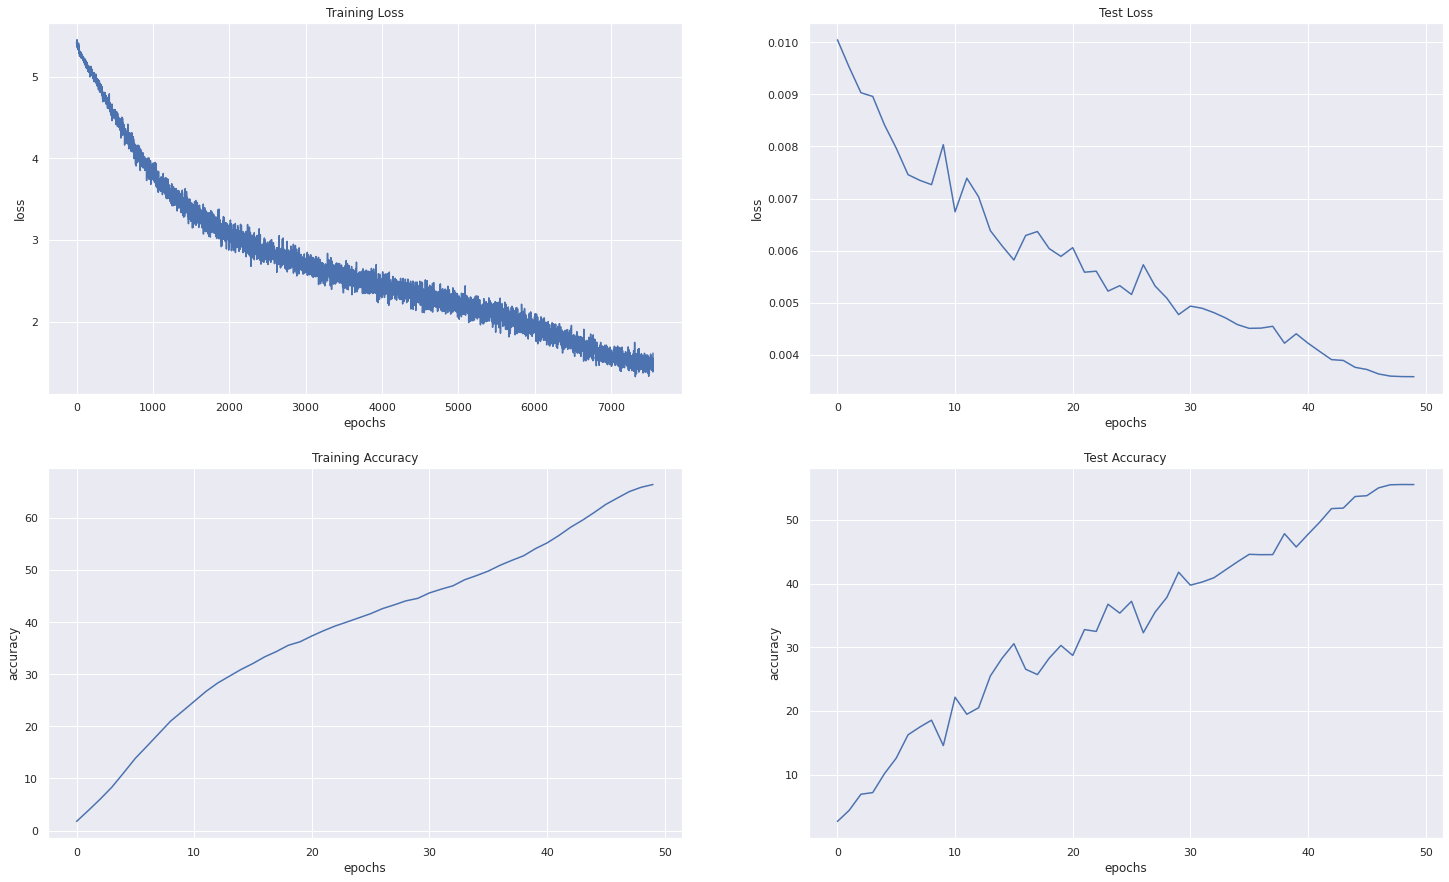

In [14]:
plot_metrics.plot_metrics(exp_metrics[experiment_name])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 14657


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


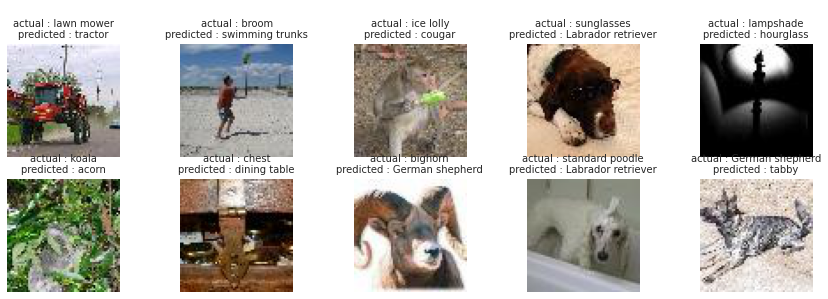

In [15]:
misclassified_images = trigger_training.wrong_predictions(model,test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([10, 200])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


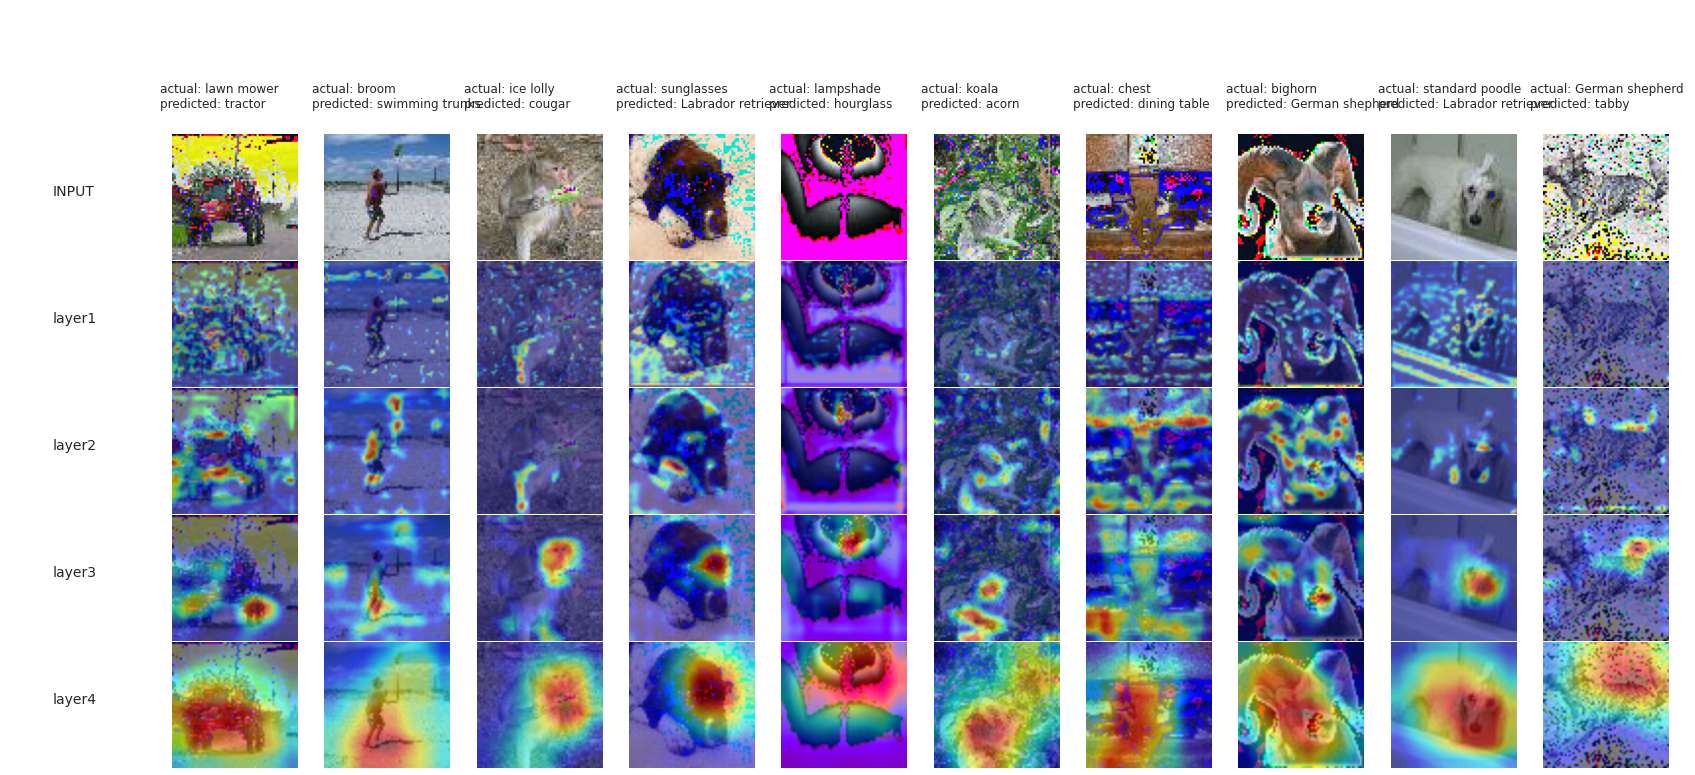

In [16]:
clas_map,_= trigger_training.get_classes()
classes = [x[1] for x in sorted(clas_map.items())]
target_layers = ["layer1","layer2","layer3","layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:10], model, target_layers,device)
plot_gradcam(gradcam_output, target_layers, classes, (3, 64, 64),predicted_classes, misclassified_images[:10])